In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler

In [2]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [5]:
# Load the dataset
data = pd.read_pickle(
    "D:\\Projects\\Solar Forcasting\\Processed Data\\Pickle files\\feature_engineered_data.pkl"
)

# Split the data based on years
train_data = data[data.index.year <= 2019]
test_data = data[data.index.year == 2020]

# Extracting the selected features and target variable "DNI"
features = [
    "Sqrt_Sum_of_Squares",
    "pca_2",
    "DNI_freq_1.429_Hz_ws_14",
    "cluster",
    "Wind Direction",
    "DNI_pse",
    "DNI_freq_1.071_Hz_ws_14",
    "DNI_freq_weighted",
    "DNI_freq_0.357_Hz_ws_14",
    "DNI_freq_0.0_Hz_ws_14",
    "DNI",  # target variable
]

train_data = train_data[features]
test_data = test_data[features]

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)


# Transform the dataset into a supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(
            df.iloc[:, -1].shift(-i)
        )  # Only take the target variable for forecasting
        if i == 0:
            names += ["var%d(t)" % (n_vars)]
        else:
            names += [("var%d(t+%d)" % (n_vars, i))]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Number of timesteps to use as input
n_timesteps = 10

train_transformed = series_to_supervised(train_data_normalized, n_timesteps, 1)
test_transformed = series_to_supervised(test_data_normalized, n_timesteps, 1)

# Split into input (X) and output (y) variables
train_X, train_y = train_transformed.values[:, :-1], train_transformed.values[:, -1]
test_X, test_y = test_transformed.values[:, :-1], test_transformed.values[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, train_data.shape[1]))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, test_data.shape[1]))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` in

In [7]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam


def create_model(trial):
    # Hyperparameters to be optimized
    lstm_units = trial.suggest_int("lstm_units", 30, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = Sequential()
    model.add(
        LSTM(
            lstm_units,
            input_shape=(train_X.shape[1], train_X.shape[2]),
            return_sequences=True,
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


def objective(trial):
    model = create_model(trial)
    history = model.fit(
        train_X, train_y, epochs=5, batch_size=64, validation_split=0.2, verbose=0
    )
    return history.history["val_loss"][-1]


# Start the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(
    objective, n_trials=10
)  # You can adjust n_trials based on how many iterations you'd like

# Print out the best hyperparameters
print("\nBest hyperparameters: ", study.best_params)

[I 2023-11-01 23:36:54,069] A new study created in memory with name: no-name-68b644f3-9491-4e0a-bcc0-6e60c9832d2d
[I 2023-11-01 23:48:57,691] Trial 0 finished with value: 3.132393248961307e-05 and parameters: {'lstm_units': 157, 'dropout_rate': 0.2568106807102779, 'learning_rate': 0.0016472928369855794}. Best is trial 0 with value: 3.132393248961307e-05.
[I 2023-11-02 00:03:53,663] Trial 1 finished with value: 0.00010184838902205229 and parameters: {'lstm_units': 172, 'dropout_rate': 0.37051846422315926, 'learning_rate': 0.0019061992586746485}. Best is trial 0 with value: 3.132393248961307e-05.
[I 2023-11-02 00:18:48,886] Trial 2 finished with value: 0.00016027690435294062 and parameters: {'lstm_units': 195, 'dropout_rate': 0.44586951624293447, 'learning_rate': 0.0035221154593481027}. Best is trial 0 with value: 3.132393248961307e-05.
[I 2023-11-02 00:29:54,738] Trial 3 finished with value: 2.3013591999188066e-05 and parameters: {'lstm_units': 110, 'dropout_rate': 0.11008920089420485, 

KeyboardInterrupt: 

Epoch 1/50
6572/6572 [==============================] - 162s 24ms/step - loss: 8.9914e-04 - val_loss: 8.7577e-05
Epoch 2/50
6572/6572 [==============================] - 151s 23ms/step - loss: 4.7459e-04 - val_loss: 6.1120e-05
Epoch 3/50
6572/6572 [==============================] - 161s 25ms/step - loss: 4.1566e-04 - val_loss: 8.2529e-05
Epoch 4/50
6572/6572 [==============================] - 127s 19ms/step - loss: 3.8267e-04 - val_loss: 5.8811e-04
Epoch 5/50
6572/6572 [==============================] - 164s 25ms/step - loss: 3.5776e-04 - val_loss: 4.3289e-05
Epoch 6/50
6572/6572 [==============================] - 170s 26ms/step - loss: 3.4757e-04 - val_loss: 5.4883e-05
Epoch 7/50
6572/6572 [==============================] - 225s 34ms/step - loss: 3.3286e-04 - val_loss: 1.4446e-04
Epoch 8/50
6572/6572 [==============================] - 182s 28ms/step - loss: 3.2890e-04 - val_loss: 2.8255e-04
Epoch 9/50
6572/6572 [==============================] - 173s 26ms/step - loss: 3.2648e-04 - val_

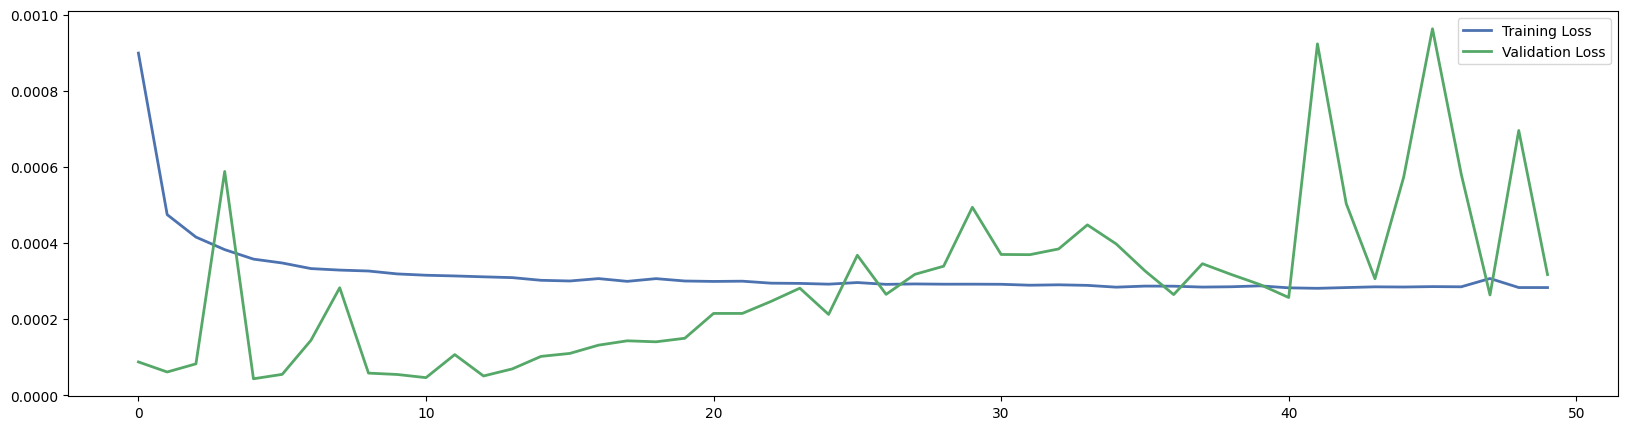

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# Best parameters from Optuna
lstm_units = 84
dropout_rate = 0.22848252726065268
learning_rate = 0.005761065964643818

# Create the RNN model with the best parameters
model = Sequential()
model.add(
    LSTM(
        lstm_units,
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True,
    )
)
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss="mse", optimizer=optimizer)

# Train the model on the training data for 50 epochs
history = model.fit(
    train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=1
)

# Optional: You can plot the training loss vs. validation loss to visualize the training process
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

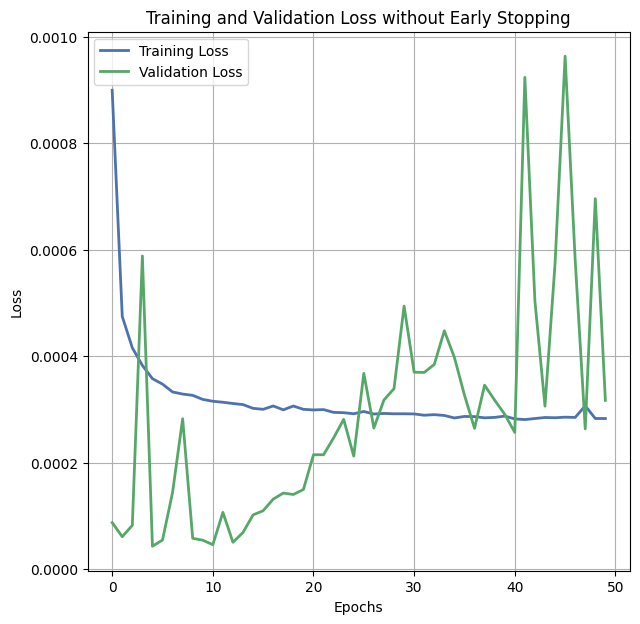

In [12]:
# Optional: You can plot the training loss vs. validation loss to visualize the training process
plt.figure(figsize=(7, 7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss without Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

1647/1647 [==============================] - 19s 11ms/step


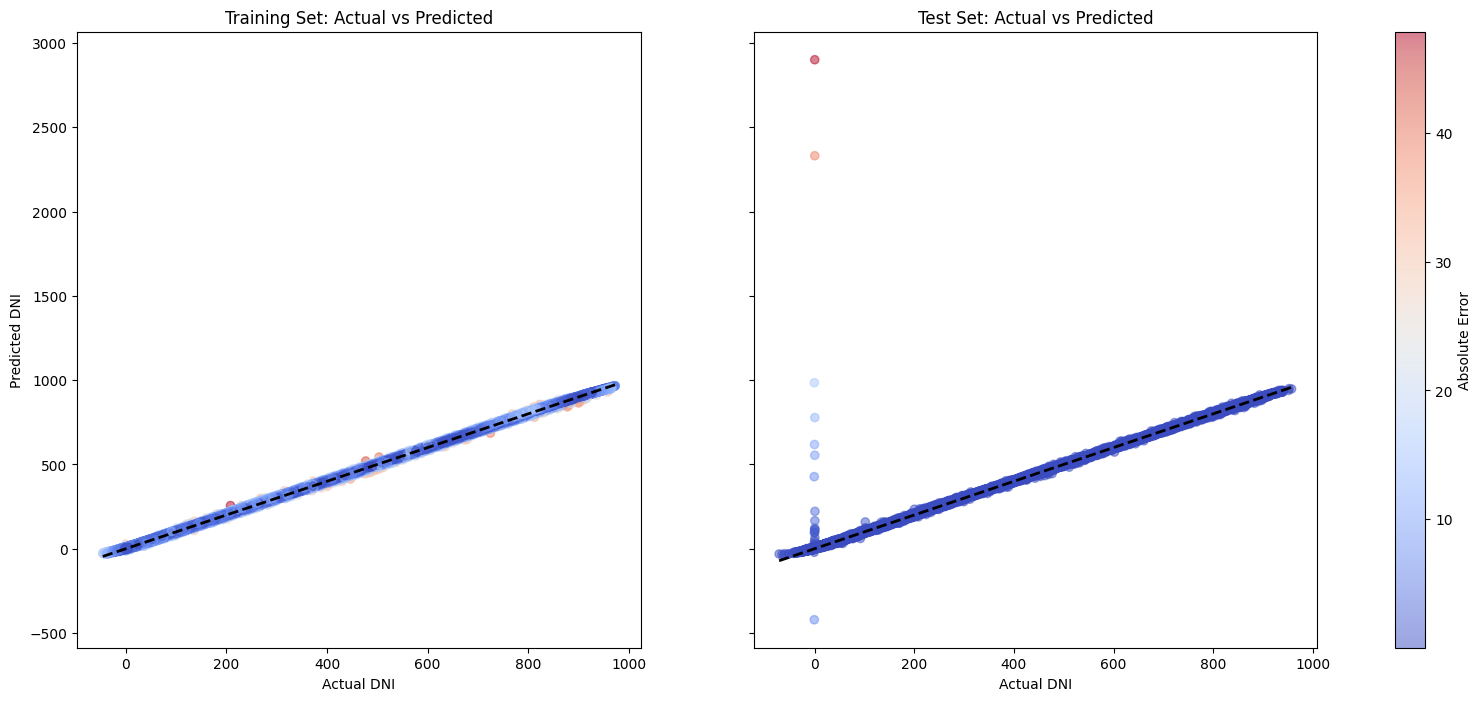

In [42]:
import matplotlib.pyplot as plt

# Assuming that `model` is your trained model and `scaler` is your MinMaxScaler instance

# Predict on the training and test sets
train_predictions_scaled = model.predict(train_X)
test_predictions_scaled = model.predict(test_X)


# Inverse scaling function
def inverse_scale(y_scaled, scaler):
    # Temporarily stack the predictions to match the number of features the scaler was trained on
    y_dummy = np.zeros((len(y_scaled), len(features) - 1))
    y_combined = np.hstack([y_dummy, y_scaled])
    # Inverse transform and then take only the last column
    y_inverse_scaled = scaler.inverse_transform(y_combined)[:, -1]
    return y_inverse_scaled


# Apply the inverse scaling to the predictions and the actual values
train_predictions = inverse_scale(train_predictions_scaled, scaler)
train_actual = inverse_scale(train_y.reshape(-1, 1), scaler)
test_predictions = inverse_scale(test_predictions_scaled, scaler)
test_actual = inverse_scale(test_y.reshape(-1, 1), scaler)

# Calculate absolute errors
train_errors = np.abs(train_actual - train_predictions)
test_errors = np.abs(test_actual - test_predictions)

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Training set
sc1 = ax[0].scatter(
    train_actual, train_predictions, c=train_errors, cmap="coolwarm", alpha=0.5
)
ax[0].plot(
    [train_actual.min(), train_actual.max()],
    [train_actual.min(), train_actual.max()],
    "k--",
)
ax[0].set_title("Training Set: Actual vs Predicted")
ax[0].set_xlabel("Actual DNI")
ax[0].set_ylabel("Predicted DNI")

# Test set
sc2 = ax[1].scatter(
    test_actual, test_predictions, c=test_errors, cmap="coolwarm", alpha=0.5
)
ax[1].plot(
    [test_actual.min(), test_actual.max()],
    [test_actual.min(), test_actual.max()],
    "k--",
)
ax[1].set_title("Test Set: Actual vs Predicted")
ax[1].set_xlabel("Actual DNI")

# Color bar
fig.colorbar(sc1, ax=ax, orientation="vertical", label="Absolute Error")

plt.show()

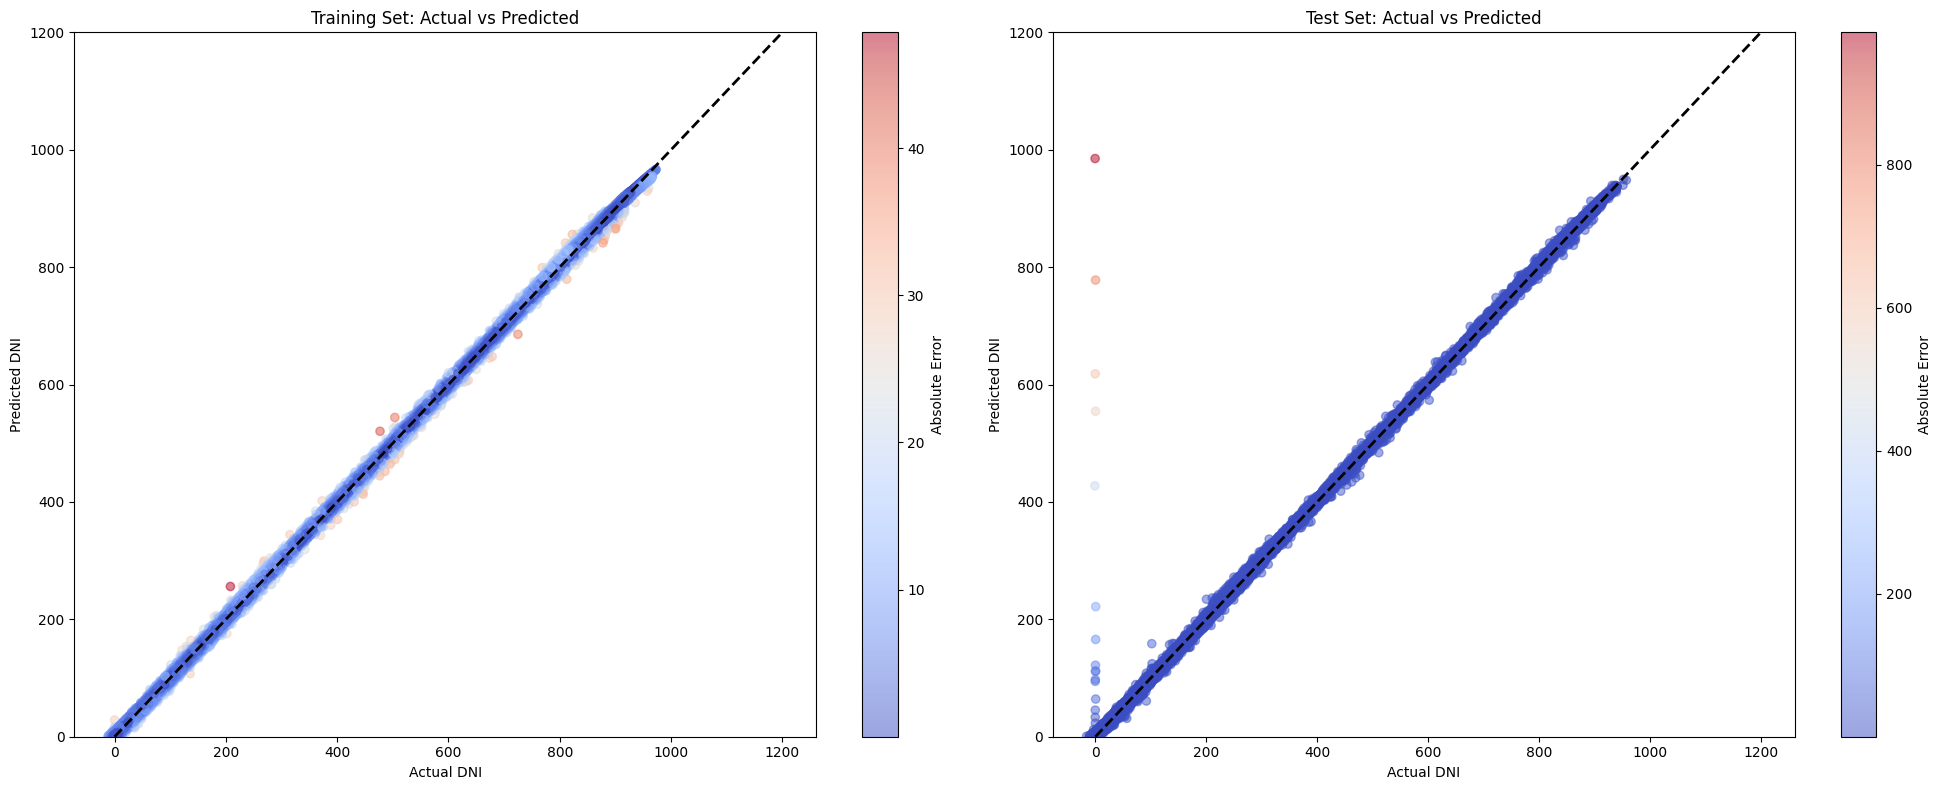

In [43]:
import matplotlib.pyplot as plt

# Filter the predictions and actual values to only include DNI values between 0 and 1200
train_mask = (train_predictions >= 0) & (train_predictions <= 1200)
test_mask = (test_predictions >= 0) & (test_predictions <= 1200)

# Apply the masks
train_predictions_filtered = train_predictions[train_mask]
train_actual_filtered = train_actual[train_mask]
train_errors_filtered = train_errors[train_mask]

test_predictions_filtered = test_predictions[test_mask]
test_actual_filtered = test_actual[test_mask]
test_errors_filtered = test_errors[test_mask]

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Training set
sc1 = ax[0].scatter(
    train_actual_filtered,
    train_predictions_filtered,
    c=train_errors_filtered,
    cmap="coolwarm",
    alpha=0.5,
)
ax[0].plot([0, 1200], [0, 1200], "k--")
ax[0].set_title("Training Set: Actual vs Predicted")
ax[0].set_xlabel("Actual DNI")
ax[0].set_ylabel("Predicted DNI")
ax[0].set_ylim(0, 1200)

# Colorbar for the training set errors
cbar1 = fig.colorbar(sc1, ax=ax[0])
cbar1.set_label("Absolute Error")

# Test set
sc2 = ax[1].scatter(
    test_actual_filtered,
    test_predictions_filtered,
    c=test_errors_filtered,
    cmap="coolwarm",
    alpha=0.5,
)
ax[1].plot([0, 1200], [0, 1200], "k--")
ax[1].set_title("Test Set: Actual vs Predicted")
ax[1].set_xlabel("Actual DNI")
ax[1].set_ylabel("Predicted DNI")  # Ensures y-axis label is shown for test set
ax[1].set_ylim(0, 1200)

# Color bar
# Colorbar for the testing set errors
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_label("Absolute Error")

plt.tight_layout()
plt.show()

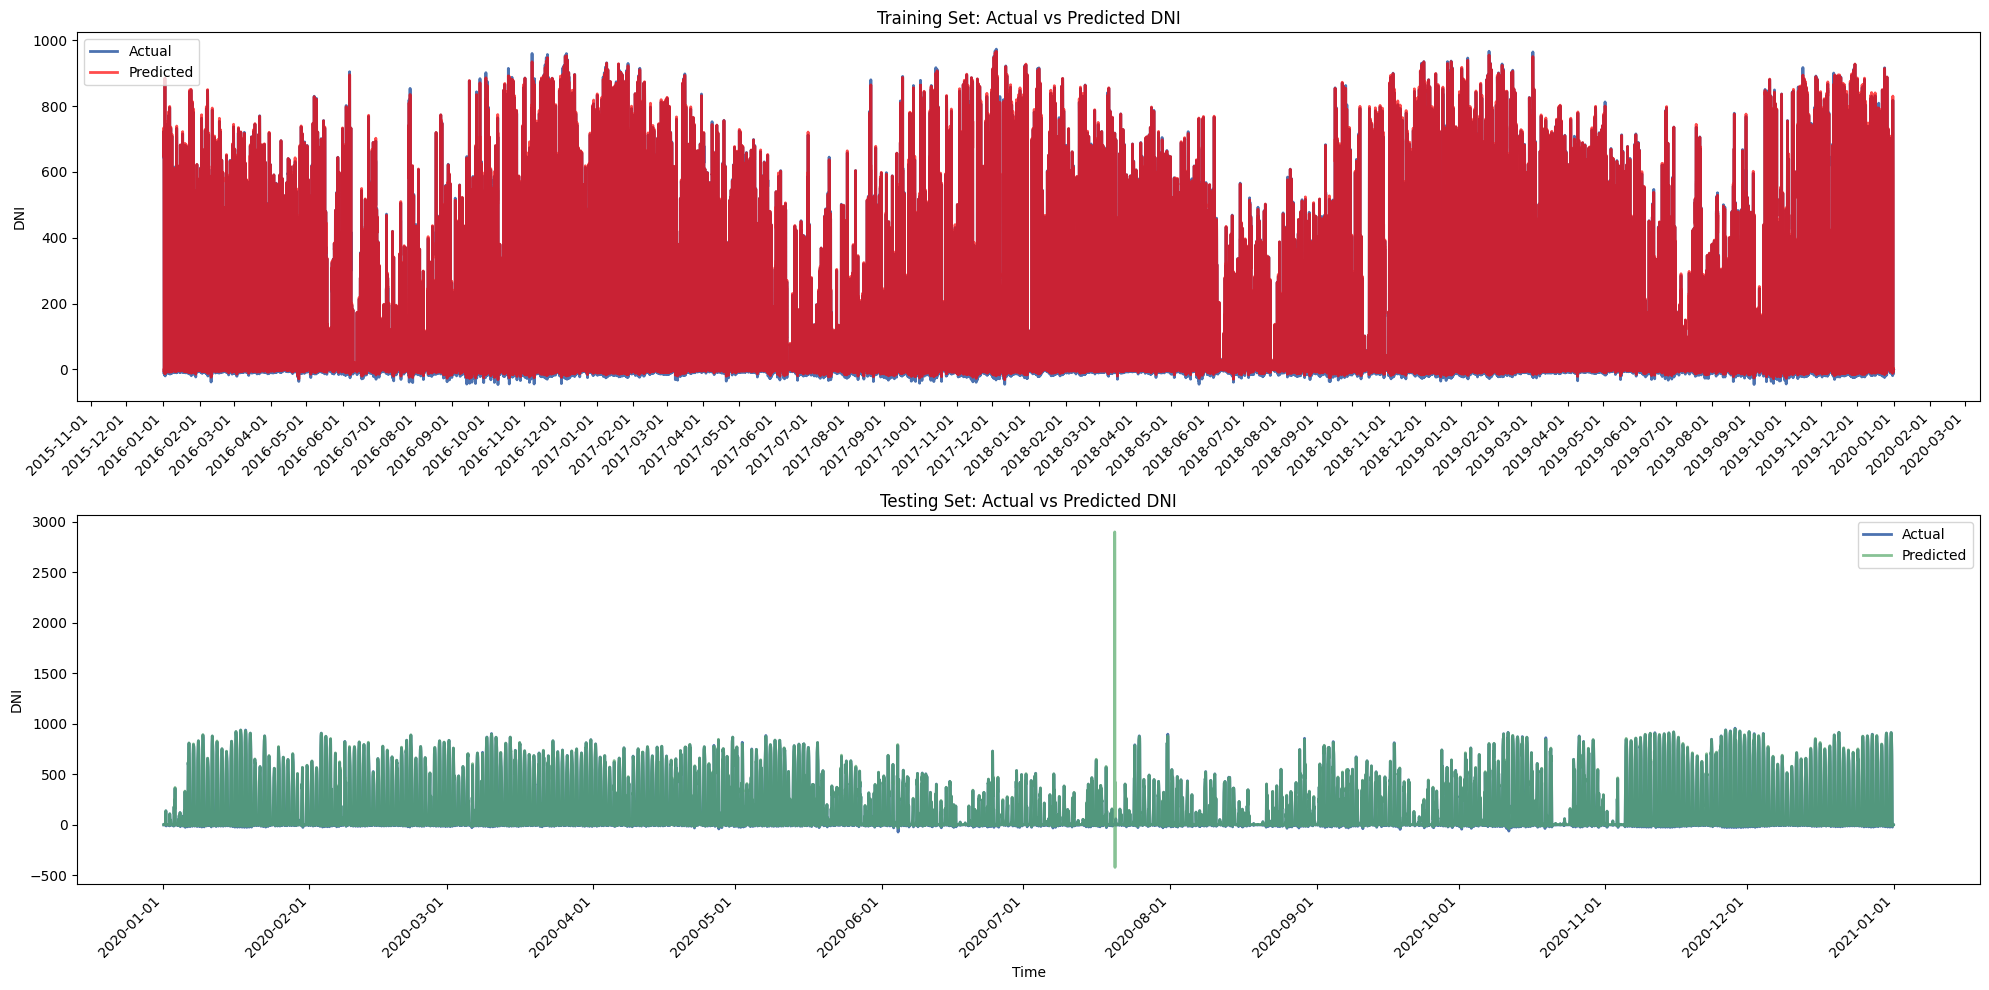

In [44]:
import matplotlib.dates as mdates

# Assuming train_data and test_data have their original time indices
train_time_index = train_data.index[n_timesteps : len(train_predictions) + n_timesteps]
test_time_index = test_data.index[n_timesteps : len(test_predictions) + n_timesteps]

# Plot actual vs predicted for training and testing sets
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Plot training actual vs predicted
ax[0].plot(train_time_index, train_actual, label="Actual")
ax[0].plot(
    train_time_index, train_predictions, color="red", label="Predicted", alpha=0.7
)
ax[0].set_title("Training Set: Actual vs Predicted DNI")
ax[0].set_ylabel("DNI")
ax[0].legend()
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right")

# Plot testing actual vs predicted
ax[1].plot(test_time_index, test_actual, label="Actual")
ax[1].plot(test_time_index, test_predictions, label="Predicted", alpha=0.7)
ax[1].set_title("Testing Set: Actual vs Predicted DNI")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("DNI")
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right")

# Improve spacing and show plot
plt.tight_layout()
plt.show()

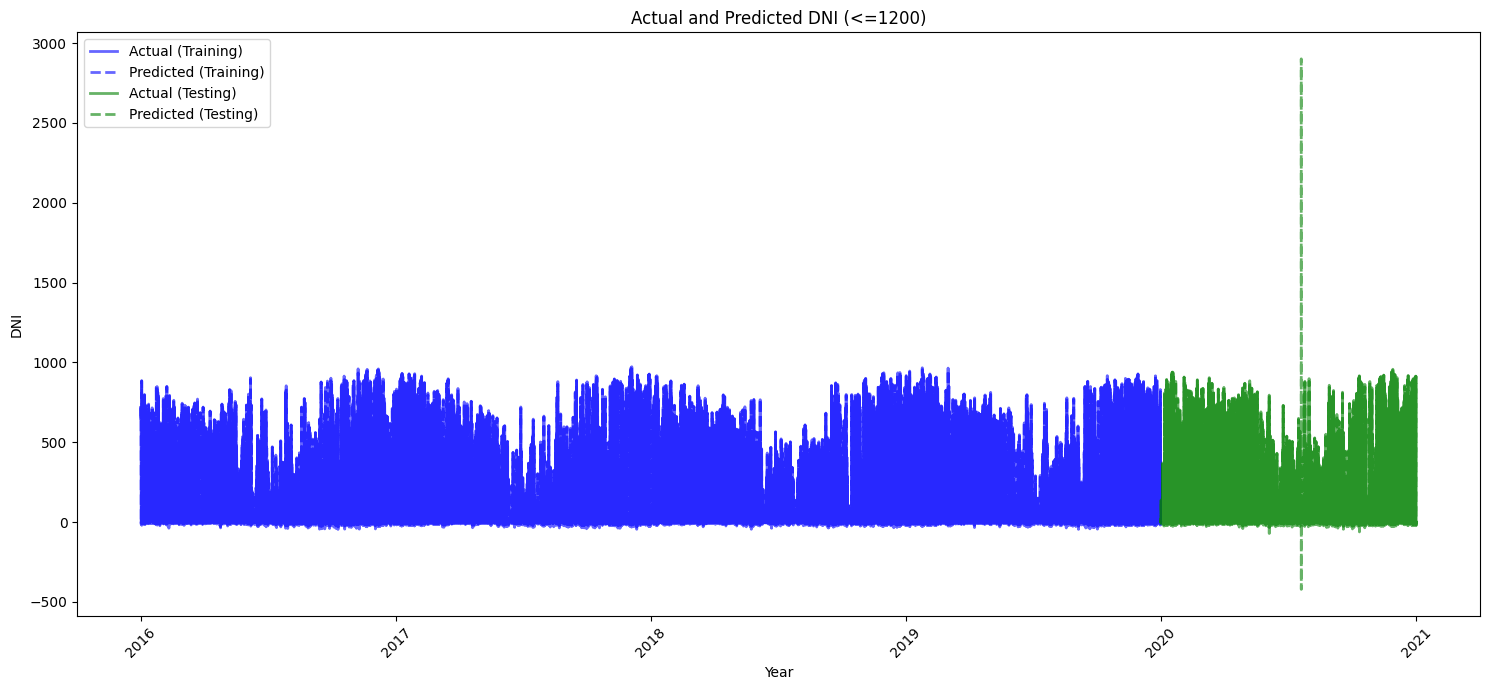

In [45]:
import matplotlib.dates as mdates

# Filter the actual and predicted data based on the DNI limit
train_mask = train_actual <= 1200
test_mask = test_actual <= 1200

# Apply the masks to the training data
filtered_train_actual = train_actual[train_mask]
filtered_train_predictions = train_predictions[train_mask]
filtered_train_time_index = train_time_index[train_mask]

# Apply the masks to the testing data
filtered_test_actual = test_actual[test_mask]
filtered_test_predictions = test_predictions[test_mask]
filtered_test_time_index = test_time_index[test_mask]

# Plot actual vs predicted for combined training and testing sets with the 1200 DNI limitation
plt.figure(figsize=(15, 7))

# Plot for the training set
plt.plot(
    filtered_train_time_index,
    filtered_train_actual,
    "b",
    label="Actual (Training)",
    alpha=0.6,
)
plt.plot(
    filtered_train_time_index,
    filtered_train_predictions,
    "b--",
    label="Predicted (Training)",
    alpha=0.6,
)

# Plot for the testing set
plt.plot(
    filtered_test_time_index,
    filtered_test_actual,
    "g",
    label="Actual (Testing)",
    alpha=0.6,
)
plt.plot(
    filtered_test_time_index,
    filtered_test_predictions,
    "g--",
    label="Predicted (Testing)",
    alpha=0.6,
)

# Set title and labels
plt.title("Actual and Predicted DNI (<=1200)")
plt.xlabel("Year")
plt.ylabel("DNI")
plt.legend()

# Set major ticks format
years = mdates.YearLocator()  # Every year
years_fmt = mdates.DateFormatter("%Y")
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt


# Calculate MAE, MSE, RMSE, and R^2 for training and testing sets
metrics = {
    "Training": {
        "MAE": mean_absolute_error(train_actual, train_predictions),
        "MSE": mean_squared_error(train_actual, train_predictions),
        "RMSE": sqrt(mean_squared_error(train_actual, train_predictions)),
        "R^2": r2_score(train_actual, train_predictions),
    },
    "Testing": {
        "MAE": mean_absolute_error(test_actual, test_predictions),
        "MSE": mean_squared_error(test_actual, test_predictions),
        "RMSE": sqrt(mean_squared_error(test_actual, test_predictions)),
        "R^2": r2_score(test_actual, test_predictions),
    },
}

# Convert the dictionary to a DataFrame for a tabular representation
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)

       Training     Testing
MAE    2.808042    3.050652
MSE   12.983136  329.101749
RMSE   3.603212   18.141162
R^2    0.999809    0.995493


In [47]:
metrics_df

,Training,Testing
MAE,2.808042,3.050652
MSE,12.983136,329.101749
RMSE,3.603212,18.141162
R^2,0.999809,0.995493


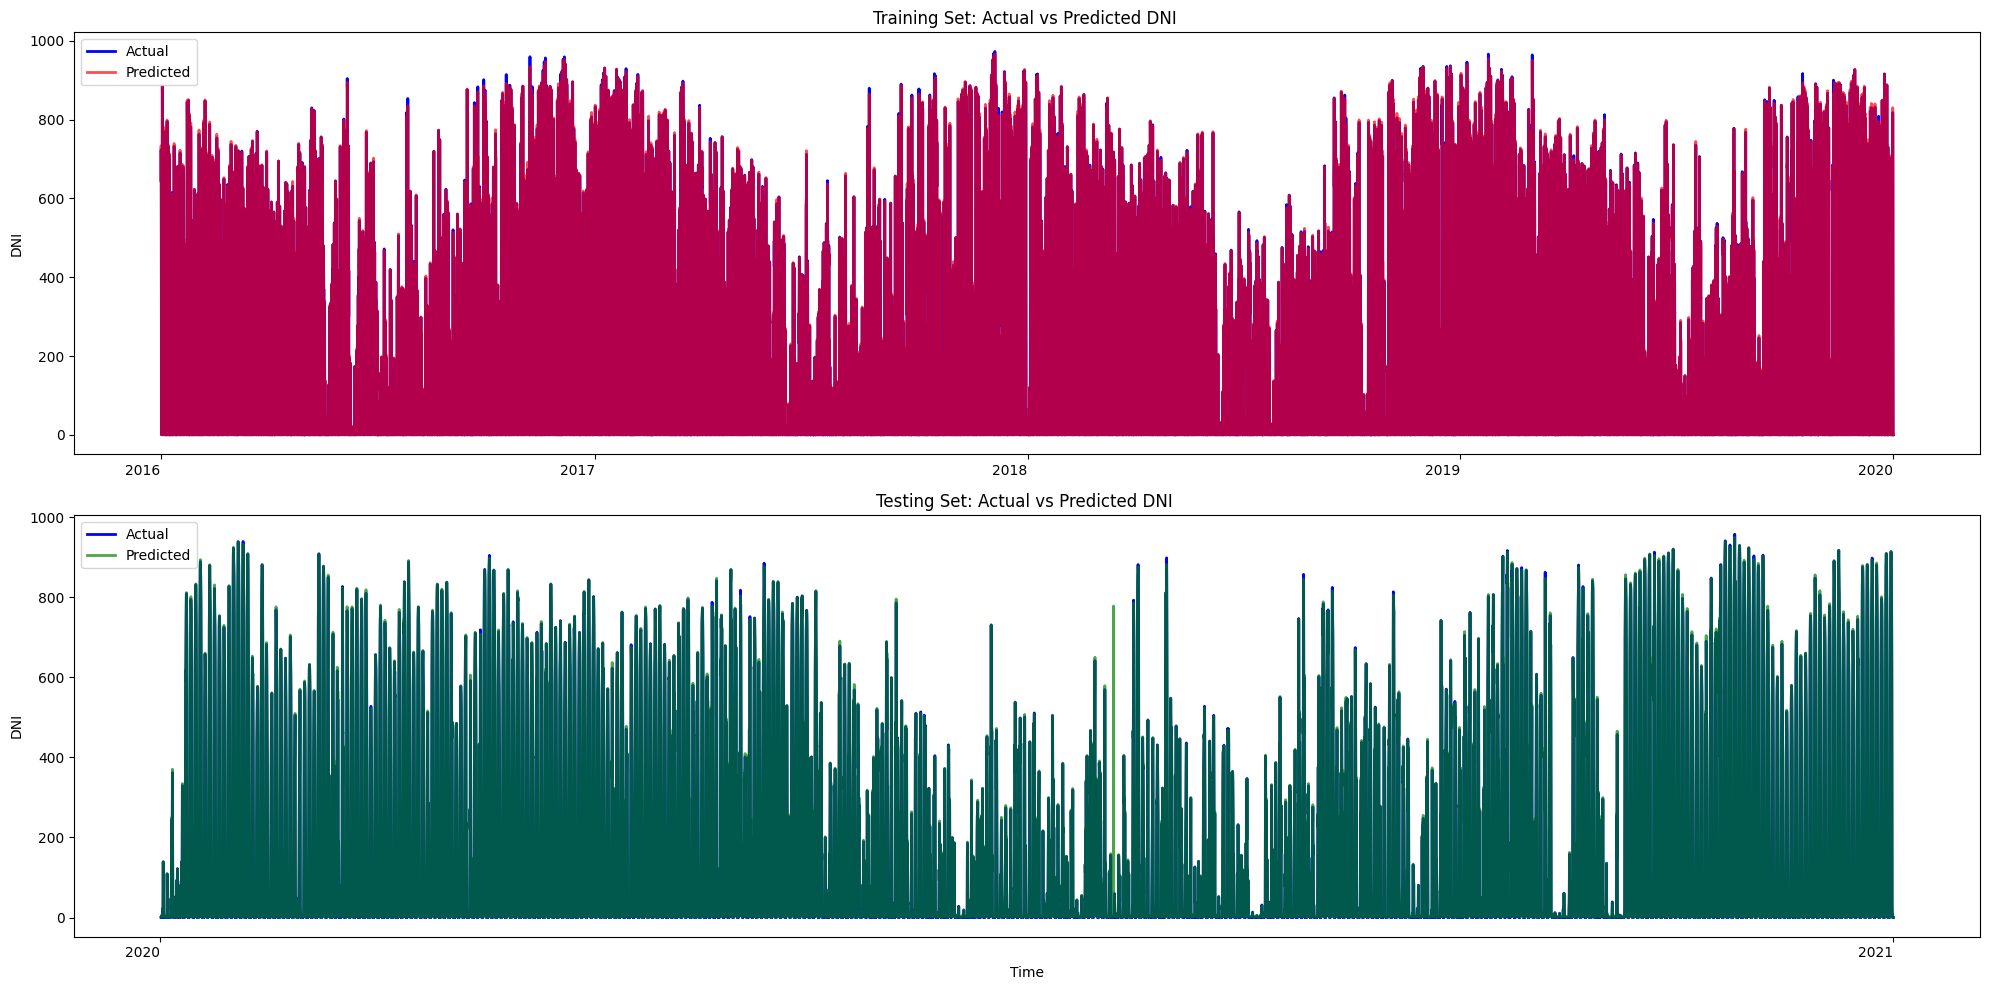

In [48]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Combine actual and predictions into DataFrames
train_df = pd.DataFrame(
    {
        "Actual": train_actual,
        "Predicted": train_predictions,
        "TimeIndex": train_time_index,
    }
)

test_df = pd.DataFrame(
    {"Actual": test_actual, "Predicted": test_predictions, "TimeIndex": test_time_index}
)

# Filter based on the condition for both actual and predicted values
# Include only DNI values >= 0 and <= 1200
filtered_train_df = train_df[
    (train_df["Actual"] >= 0)
    & (train_df["Actual"] <= 1200)
    & (train_df["Predicted"] >= 0)
    & (train_df["Predicted"] <= 1200)
]
filtered_test_df = test_df[
    (test_df["Actual"] >= 0)
    & (test_df["Actual"] <= 1200)
    & (test_df["Predicted"] >= 0)
    & (test_df["Predicted"] <= 1200)
]

# Plot the filtered actual vs predicted for training and testing sets
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Training set plot
ax[0].plot(
    filtered_train_df["TimeIndex"],
    filtered_train_df["Actual"],
    color="blue",
    label="Actual",
)
ax[0].plot(
    filtered_train_df["TimeIndex"],
    filtered_train_df["Predicted"],
    color="red",
    label="Predicted",
    alpha=0.7,
)
ax[0].set_title("Training Set: Actual vs Predicted DNI ")
ax[0].set_ylabel("DNI")
ax[0].legend()
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[0].xaxis.set_major_locator(mdates.YearLocator())

# Testing set plot
ax[1].plot(
    filtered_test_df["TimeIndex"],
    filtered_test_df["Actual"],
    color="blue",
    label="Actual",
)
ax[1].plot(
    filtered_test_df["TimeIndex"],
    filtered_test_df["Predicted"],
    color="green",
    label="Predicted",
    alpha=0.7,
)
ax[1].set_title("Testing Set: Actual vs Predicted DNI ")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("DNI")
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[1].xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels and improve spacing
plt.setp(ax[0].get_xticklabels(), ha="right")
plt.setp(ax[1].get_xticklabels(), ha="right")
plt.tight_layout()
plt.show()

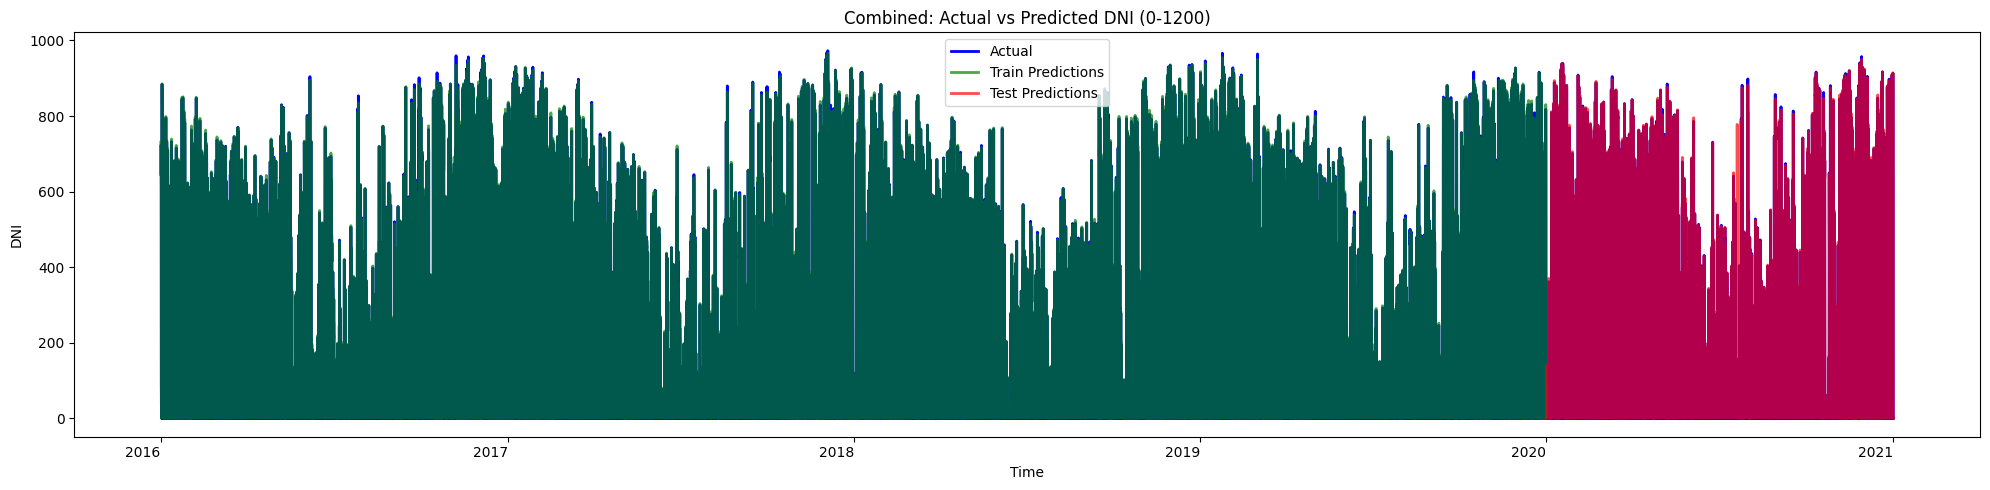

In [51]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Combine actual and predictions into DataFrames
combined_df = pd.concat([filtered_train_df, filtered_test_df])

# Plot the filtered actual vs predicted for combined training and testing sets
plt.figure(figsize=(20, 5))

# Plot combined actual values
plt.plot(combined_df["TimeIndex"], combined_df["Actual"], color="blue", label="Actual")

# Plot combined training set predictions
# Note that for the training predictions, we plot them only for the training period
plt.plot(
    filtered_train_df["TimeIndex"],
    filtered_train_df["Predicted"],
    color="green",
    label="Train Predictions",
    alpha=0.7,
)

# Plot combined testing set predictions
# Note that for the testing predictions, we plot them only for the testing period
plt.plot(
    filtered_test_df["TimeIndex"],
    filtered_test_df["Predicted"],
    color="red",
    label="Test Predictions",
    alpha=0.7,
)

# Formatting the plot
plt.title("Combined: Actual vs Predicted DNI (0-1200)")
plt.xlabel("Time")
plt.ylabel("DNI")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.setp(plt.gca().get_xticklabels(), ha="right")

# Show the plot
plt.tight_layout()
plt.show()

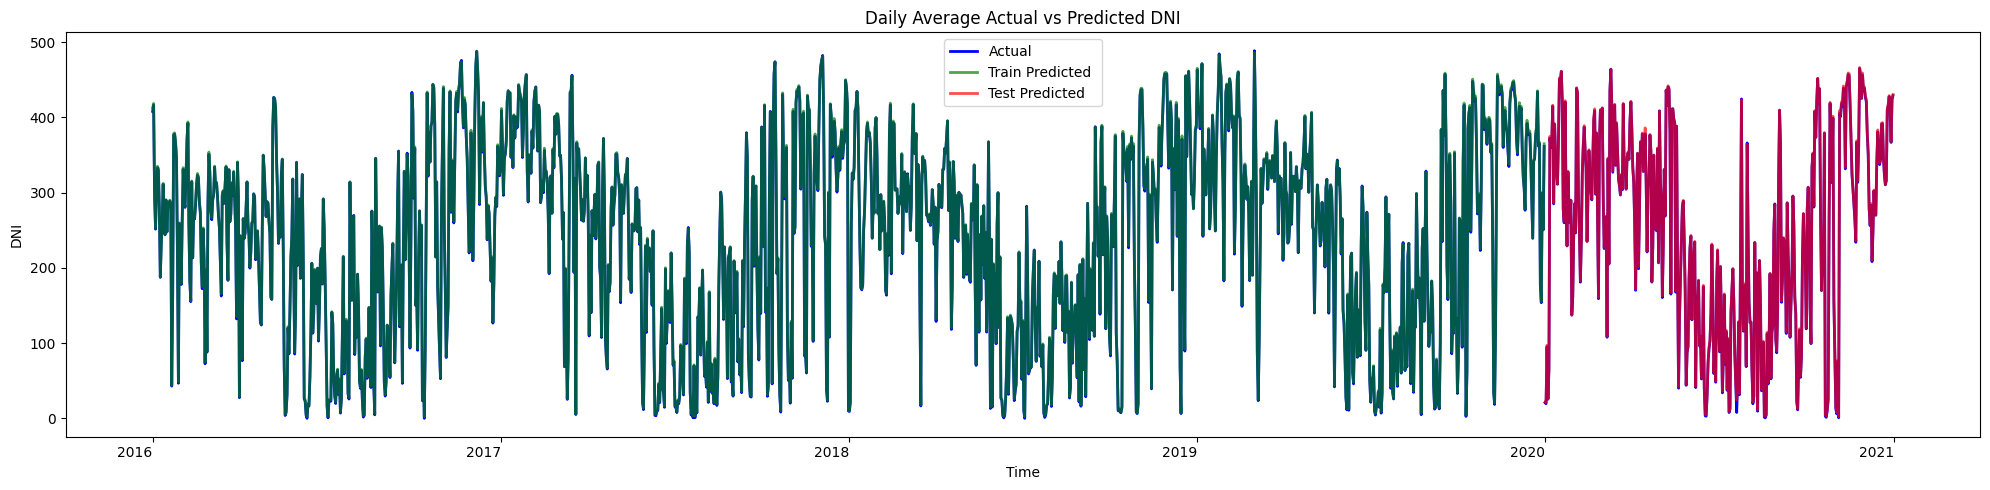

In [56]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Assuming filtered_train_df and filtered_test_df are already defined and include columns 'Actual', 'Predicted', and 'TimeIndex'

# Resample to daily data for actual and predicted, taking the mean for each day
daily_train_df = filtered_train_df.resample("D", on="TimeIndex").mean()
daily_test_df = filtered_test_df.resample("D", on="TimeIndex").mean()

# Plot the daily averages actual vs predicted for combined training and testing sets
plt.figure(figsize=(20, 5))

# Plot daily average actual values for training
plt.plot(
    daily_train_df.index,
    daily_train_df["Actual"],
    color="blue",
    label="Actual",
)

# Plot daily average predicted values for training
plt.plot(
    daily_train_df.index,
    daily_train_df["Predicted"],
    color="green",
    label="Train Predicted ",
    alpha=0.7,
)

# Plot daily average actual values for testing
plt.plot(
    daily_test_df.index,
    daily_test_df["Actual"],
    color="blue",
)

# Plot daily average predicted values for testing
plt.plot(
    daily_test_df.index,
    daily_test_df["Predicted"],
    color="red",
    label="Test Predicted ",
    alpha=0.7,
)

# Formatting the plot
plt.title("Daily Average Actual vs Predicted DNI")
plt.xlabel("Time")
plt.ylabel("DNI")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.setp(plt.gca().get_xticklabels(), ha="right")

# Show the plot
plt.tight_layout()
plt.show()

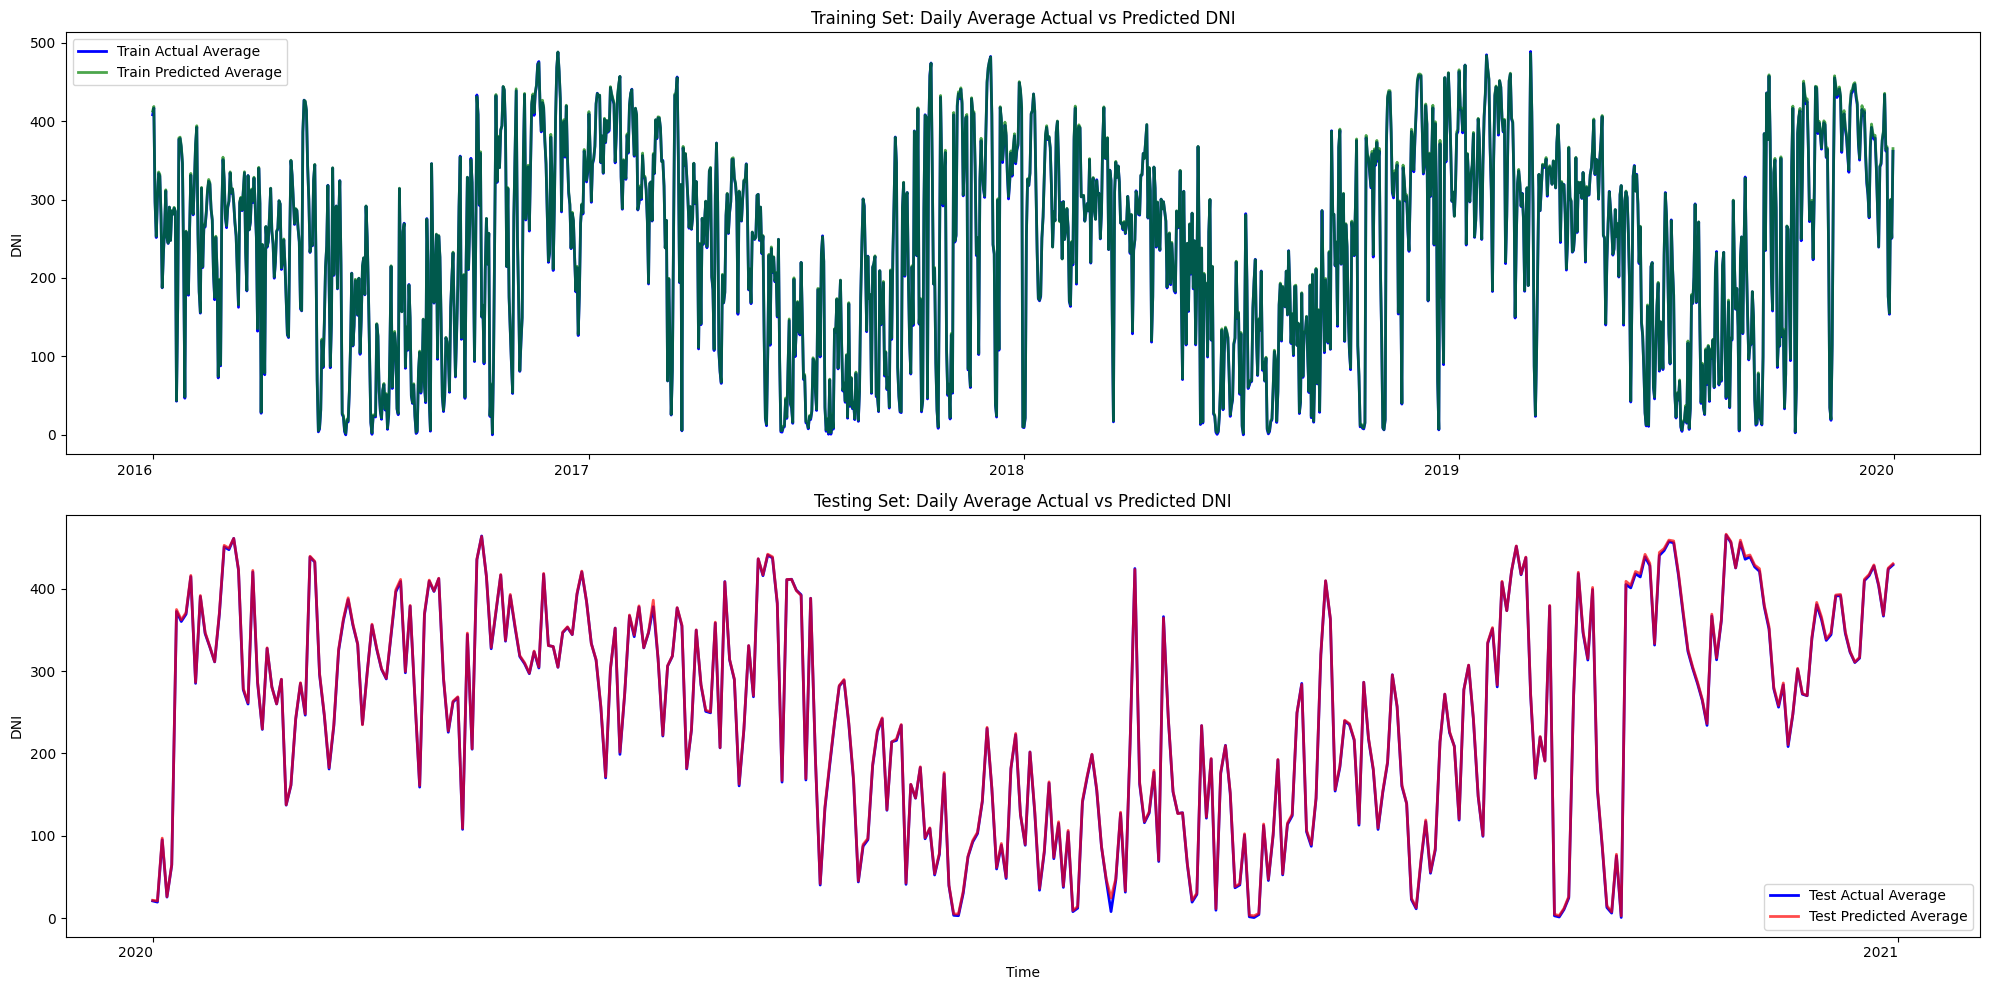

In [60]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Assuming filtered_train_df and filtered_test_df are already defined and include columns 'Actual', 'Predicted', and 'TimeIndex'

# Resample to daily data for actual and predicted, taking the mean for each day
daily_train_df = filtered_train_df.resample("D", on="TimeIndex").mean()
daily_test_df = filtered_test_df.resample("D", on="TimeIndex").mean()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot daily average actual vs predicted for training set
axes[0].plot(
    daily_train_df.index,
    daily_train_df["Actual"],
    color="blue",
    label="Train Actual Average",
)
axes[0].plot(
    daily_train_df.index,
    daily_train_df["Predicted"],
    color="green",
    label="Train Predicted Average",
    alpha=0.7,
)
axes[0].set_title("Training Set: Daily Average Actual vs Predicted DNI")
axes[0].set_ylabel("DNI")
axes[0].legend()

# Plot daily average actual vs predicted for testing set
axes[1].plot(
    daily_test_df.index,
    daily_test_df["Actual"],
    color="blue",
    label="Test Actual Average",
)
axes[1].plot(
    daily_test_df.index,
    daily_test_df["Predicted"],
    color="red",
    label="Test Predicted Average",
    alpha=0.7,
)
axes[1].set_title("Testing Set: Daily Average Actual vs Predicted DNI")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("DNI")
axes[1].legend()

# Formatting the plots
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.get_xticklabels(), ha="right")

# Improve spacing between plots
plt.tight_layout()
plt.show()